## Constants

In [7]:
LABELS = '../data/raw/labels.csv'
TRAIN = '../data/raw/train/'
TEST = '../data/raw/test/'
MODEL_PATH = '../models/'

## Import tools

In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf 
import tensorflow_hub as hub
from IPython.display import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Reading data

In [9]:
labels_df = pd.read_csv(LABELS)
labels_df['id'] = labels_df['id'] + '.jpg'

In [10]:
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


### Most breeds we have

In [11]:
labels_df['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

<AxesSubplot:>

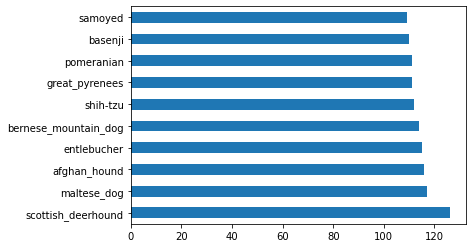

In [12]:
labels_df['breed'].value_counts().head(10).plot(kind='barh')

### Distribution of classes freq

<AxesSubplot:>

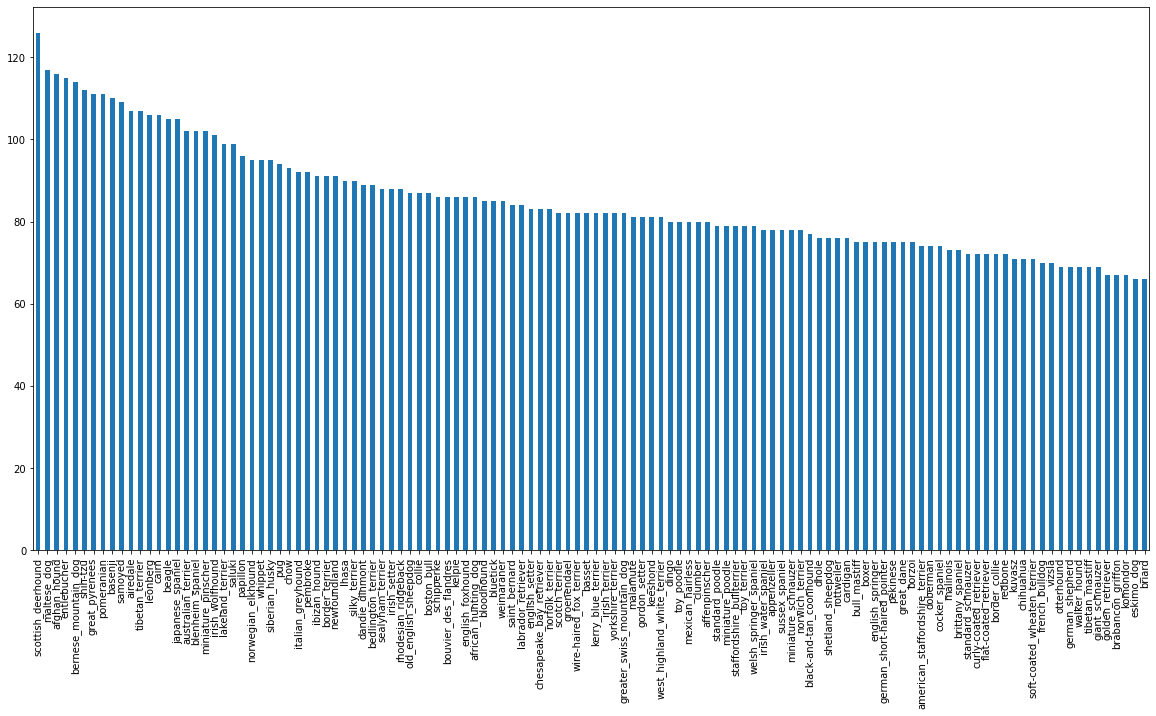

In [13]:
labels_df['breed'].value_counts().plot.bar(figsize=(20,10))

### Display image

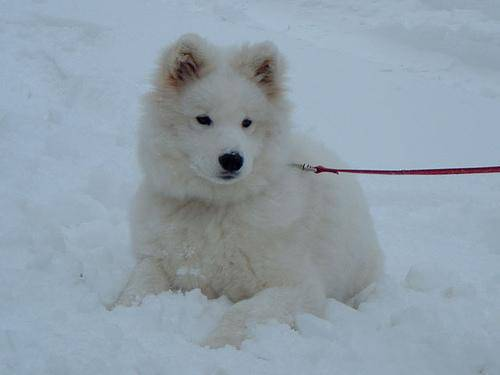

In [14]:
Image(str(TRAIN) + str(labels_df['id'][70]))

### Store pathes of images into list

In [15]:
filenames = [TRAIN + fname for fname in labels_df['id']]

In [16]:
filenames[:10]

['../data/raw/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '../data/raw/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '../data/raw/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '../data/raw/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '../data/raw/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '../data/raw/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '../data/raw/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '../data/raw/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '../data/raw/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '../data/raw/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

### Recheck

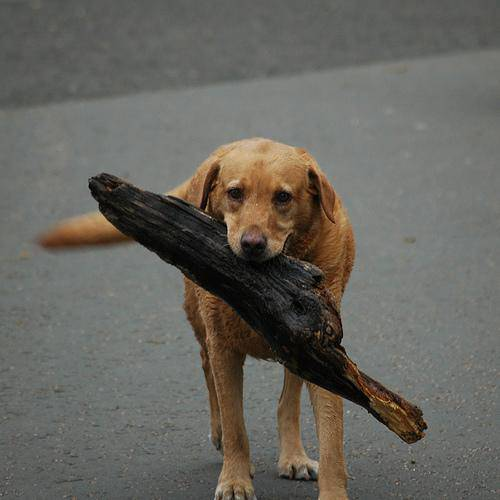

In [17]:
Image(filenames[4])

In [18]:
labels_df['breed'][4]

'golden_retriever'

## Convert data into numbers

In [19]:
breeds = np.array(labels_df['breed'])
len(breeds)

10222

### Get boolean labels

In [20]:
unique_breeds = np.unique(breeds)
bool_labels = [label == unique_breeds for label in breeds]

In [21]:
bool_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [22]:
len(bool_labels)

10222

## Creating Train/test split

In [23]:
# Setup X & y variables
X = filenames
y = bool_labels

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X[:5000], y[:5000], test_size=0.2)

len(X_train), len(y_train), len(X_test), len(y_test)


(4000, 4000, 1000, 1000)

In [25]:
X_train[:5], y_train[:2]

(['../data/raw/train/02b1c50fb7315423a664f3ce68c94e30.jpg',
  '../data/raw/train/20bfa7dbc9f7b226f94f0addd0b4d141.jpg',
  '../data/raw/train/3f5429aed0055c3e6fa9564c98c32008.jpg',
  '../data/raw/train/5c10ef73c24f59a1d29fedc3db169124.jpg',
  '../data/raw/train/778e71af58e7431ccc91543e5d645f73.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False,  True, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, 

### process images function

In [26]:
# Define the shape of image (224, 224)
IMG_size = 224

In [27]:
def process_image(image_path):
    """
    Taking path of an image and turn it into tensor
    """
    
    # Read an image file
    image = tf.io.read_file(image_path)
    
    # Convert the image into tensor
    image = tf.image.decode_jpeg(image, channels=3)

    # Convert color channel values from 0-255 to 0-1
    image = tf.image.convert_image_dtype(image, tf.float32)

    # Resize the image shape (244,244)
    image = tf.image.resize(image, size=[IMG_size, IMG_size])

    return image


In [28]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

## Turn data into batches

In [29]:
# Define batch size
BATCH_SIZE = 32

# Create function to turn data into batches

def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    """
    Split the data into batches
    """

    # If we have test dataset, we don't need labels
    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        return data_batch

    # If we have valid data set, we need to shuffle the data
    elif valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
        tf.constant(y)))
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch

    else:
        print('Creating training data batches...')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
        tf.constant(y)))

        # Shuffling pathnames and labels before mapping
        data = data.shuffle(buffer_size=len(X))
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch

In [30]:
train_data = create_data_batches(X_train, y_train)
test_data = create_data_batches(X_train, y_train, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [31]:
train_data.element_spec, ' ' , test_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 ' ',
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

### Display 25 images function

In [32]:
def show_25_images(images, labels):
    """
    Display 25 images and theier labels from the batch
    """

    plt.figure(figsize=(15,15))

    for i in range(25):
        ax = plt.subplot(5,5, i+1)
        plt.imshow(images[i])
        plt.title(unique_breeds[labels[i].argmax()])
        plt.axis('off')


### Convert the batch into iteretable data 

In [33]:
train_images, train_labels = next(train_data.as_numpy_iterator())

len(train_images), len(train_labels)

(32, 32)

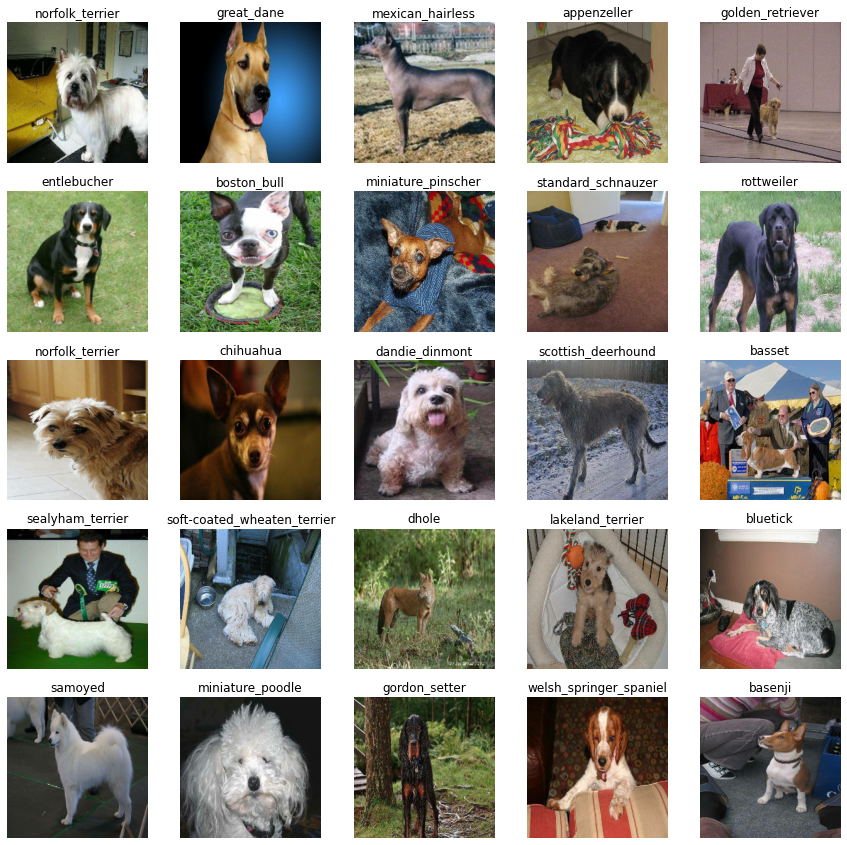

In [34]:
show_25_images(train_images, train_labels)

## Setup the input and output

In [35]:
INPUT_SHAPE = [None, IMG_size, IMG_size, 3]
OUTPUT_SHAPE = len(unique_breeds)   
MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/classification/5'

In [36]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE):

    # Load the model
    model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE, 
                          activation="softmax") # Layer 2 (output layer)
    ])
    

    # Compile the model
    model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), # Our model wants to reduce this (how wrong its guesses are)
      optimizer=tf.keras.optimizers.Adam(), # A friend telling our model how to improve its guesses
      metrics=["accuracy"] # We'd like this to go up
    )

    # Build the model
    model.build(INPUT_SHAPE)

    return model

## Building the model

In [37]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              4013897   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 4,134,137
Trainable params: 120,240
Non-trainable params: 4,013,897
_________________________________________________________________


In [38]:
%load_ext tensorboard

## Create a tensorflow board

In [40]:
import datetime
import os
# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("../models/",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Handle early stopping

In [41]:
# Create early stopping (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3) # stops after 3 rounds of no improvements

## Training the model

In [42]:
EPOCHES = 100

In [43]:
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=EPOCHES,
            validation_data=test_data,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[tensorboard, early_stopping])
  
  return model

In [44]:
model = train_model()

Epoch 1/100
  1/125 [..............................] - ETA: 0s - loss: 5.8365 - accuracy: 0.0000e+00WARNING:tensorflow:From F:\PROGRAMS\Programming\anaconda\envs\DS\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


  2/125 [..............................] - ETA: 3:24 - loss: 5.7201 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.9442s vs `on_train_batch_end` time: 2.3757s). Check your callbacks.


125/125 [==============================] - 298s 2s/step - loss: 2.5624 - accuracy: 0.4342 - val_loss: 0.6325 - val_accuracy: 0.8558
Epoch 2/100
125/125 [==============================] - 191s 2s/step - loss: 0.5752 - accuracy: 0.8547 - val_loss: 0.2604 - val_accuracy: 0.9588
Epoch 3/100
125/125 [==============================] - 185s 1s/step - loss: 0.2664 - accuracy: 0.9535 - val_loss: 0.1422 - val_accuracy: 0.9870
Epoch 4/100
125/125 [==============================] - 194s 2s/step - loss: 0.1476 - accuracy: 0.9827 - val_loss: 0.0893 - val_accuracy: 0.9970
Epoch 5/100
125/125 [==============================] - 184s 1s/step - loss: 0.0925 - accuracy: 0.9952 - val_loss: 0.0629 - val_accuracy: 0.9977
Epoch 6/100
125/125 [==============================] - 181s 1s/step - loss: 0.0653 - accuracy: 0.9970 - val_loss: 0.0458 - val_accuracy: 0.9995
Epoch 7/100
125/125 [==============================] - 184s 1s/step - loss: 0.0492 - accuracy: 0.9992 - val_loss: 0.0363 - val_accuracy: 0.9998
Epoc

## Predict test data

In [46]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(test_data, verbose=1) # verbose shows us how long there is to go
predictions

125/125 [==============================] - 100s 800ms/step


array([[4.1748853e-09, 3.0597496e-07, 2.2208438e-05, ..., 4.3370066e-05,
        1.2792796e-07, 9.0926370e-08],
       [4.1150179e-06, 1.4830130e-05, 1.6080392e-06, ..., 9.4023221e-07,
        1.8955312e-05, 7.6539873e-06],
       [1.8657468e-08, 9.4871109e-07, 2.9954458e-06, ..., 5.3174417e-06,
        3.0624271e-08, 5.0415156e-06],
       ...,
       [1.0593948e-03, 1.9076708e-05, 3.1565608e-07, ..., 1.7509536e-06,
        2.9696021e-05, 3.5786964e-06],
       [4.3065879e-06, 7.0763753e-07, 9.5204105e-06, ..., 7.1501207e-05,
        9.7267061e-01, 5.4964272e-04],
       [9.0508638e-07, 2.6184985e-05, 6.2858197e-07, ..., 5.1301486e-06,
        3.8828674e-08, 3.1558295e-07]], dtype=float32)

In [49]:
#print(predictions[0])
print(np.argmax(predictions[0]))
print(unique_breeds[np.argmax(predictions[0])])

37
dingo


In [57]:
images = []
labels = []
for i,l in test_data.unbatch().as_numpy_iterator():
    images.append(i)
    labels.append(unique_breeds[np.argmax(l)])

(-0.5, 223.5, 223.5, -0.5)

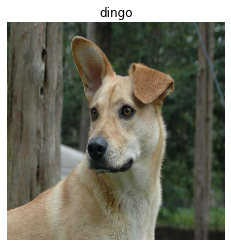

In [59]:
plt.imshow(images[0])
plt.title(labels[0])
plt.axis('off')